In [ ]:
!pip install sdv

In [2]:
from sdv.timeseries import PAR
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from pickle import dump, load

In [3]:
# https://www.kaggle.com/code/xiaxiaxu/predictmachinefailureinadvance/data
sensor = pd.read_csv('sensor.csv') 

# only keeping cols w high var in pca analysis + machine status
data = sensor[['timestamp', 'sensor_25', 'sensor_11', 'sensor_36', 'sensor_34', 'machine_status']]

In [4]:
# okay, what can our machine status be?

# data = data.convert_dtypes()
print(data.dtypes, '\n')
data['timestamp']= pd.to_datetime(data['timestamp'])

data.machine_status.unique()

timestamp          object
sensor_25         float64
sensor_11         float64
sensor_36         float64
sensor_34         float64
machine_status     object
dtype: object 



/tmp/ipykernel_9612/1293169788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp']= pd.to_datetime(data['timestamp'])


array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [5]:
data.loc[data['machine_status'] == 'BROKEN']

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
17155,2018-04-12 21:55:00,653.9383,3.625588,301.1411,261.7709,BROKEN
24510,2018-04-18 00:30:00,650.4600,30.434710,434.2556,177.4708,BROKEN
69318,2018-05-19 03:18:00,719.8438,43.623220,285.3491,171.3203,BROKEN
77790,2018-05-25 00:30:00,746.0360,44.793620,250.9113,171.7490,BROKEN
128040,2018-06-28 22:00:00,143.1029,1.960537,367.8615,343.9342,BROKEN
141131,2018-07-08 00:11:00,759.8998,23.970270,616.8983,287.9145,BROKEN
166440,2018-07-25 14:00:00,740.6738,50.046190,812.8298,363.0320,BROKEN


In [6]:
data_around_failures = data.iloc[16000:26000]
len(data_around_failures)

10000

In [7]:
print(data_around_failures[data_around_failures.isna().any(axis=1)])

# we only have one row with NA, let's simply drop that.

data_around_failures.dropna(axis=0, inplace=True)

print(data_around_failures[data_around_failures.isna().any(axis=1)])

                timestamp  sensor_25  sensor_11  sensor_36  sensor_34  \
25112 2018-04-18 10:32:00   778.3798        NaN   320.4606   168.2153   

      machine_status  
25112     RECOVERING  
Empty DataFrame
Columns: [timestamp, sensor_25, sensor_11, sensor_36, sensor_34, machine_status]
Index: []


/tmp/ipykernel_9612/695179921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_around_failures.dropna(axis=0, inplace=True)


In [14]:
scaler = MinMaxScaler((-1,1))
sensor_cols = ['sensor_25', 'sensor_11', 'sensor_36', 'sensor_34']

# scaling our data, then saving our scaler object for future use.
data_around_failures[sensor_cols] = scaler.fit_transform(data_around_failures[sensor_cols])

dump(scaler, open('scaler_2.pkl', 'wb'))

/tmp/ipykernel_9612/227989069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_around_failures[sensor_cols] = scaler.fit_transform(data_around_failures[sensor_cols])
/opt/app-root/lib64/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [9]:
data_around_failures.head()

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
16000,2018-04-12 02:40:00,-0.365892,0.753564,-0.715956,-0.422625,NORMAL
16001,2018-04-12 02:41:00,-0.339668,0.794118,-0.723864,-0.402944,NORMAL
16002,2018-04-12 02:42:00,-0.355702,0.799705,-0.699396,-0.383268,NORMAL
16003,2018-04-12 02:43:00,-0.364130,0.823757,-0.729806,-0.360489,NORMAL
16004,2018-04-12 02:44:00,-0.422890,0.816034,-0.717692,-0.344245,NORMAL


In [10]:
# finding number of times machine status is diff vars

n = data_around_failures.machine_status.value_counts()
print(n)

NORMAL        7565
RECOVERING    2432
BROKEN           2
Name: machine_status, dtype: int64


In [11]:
# going to try to keep every 2 mins rather than every min

thin_data = data_around_failures[data_around_failures.index % 2 == 0]
thin_data

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
16000,2018-04-12 02:40:00,-0.365892,0.753564,-0.715956,-0.422625,NORMAL
16002,2018-04-12 02:42:00,-0.355702,0.799705,-0.699396,-0.383268,NORMAL
16004,2018-04-12 02:44:00,-0.422890,0.816034,-0.717692,-0.344245,NORMAL
16006,2018-04-12 02:46:00,-0.395750,0.768888,-0.711339,-0.354285,NORMAL
16008,2018-04-12 02:48:00,-0.252140,0.760246,-0.709943,-0.336067,NORMAL
...,...,...,...,...,...,...
25990,2018-04-19 01:10:00,-0.389142,-1.000000,-0.729133,-0.154069,RECOVERING
25992,2018-04-19 01:12:00,-0.348781,-1.000000,-0.717811,-0.170048,RECOVERING
25994,2018-04-19 01:14:00,-0.351101,-1.000000,-0.718568,-0.149997,RECOVERING
25996,2018-04-19 01:16:00,-0.370254,-1.000000,-0.717221,-0.130279,RECOVERING


In [12]:
# thin_data = thin_data.convert_dtypes()

print(thin_data.dtypes, '\n')

timestamp         datetime64[ns]
sensor_25                float64
sensor_11                float64
sensor_36                float64
sensor_34                float64
machine_status            object
dtype: object 



In [15]:
sequence_index = 'timestamp'
# context_columns = ['machine_status']
context_columns = None

In [16]:
model = PAR(sequence_index = sequence_index, context_columns=context_columns, verbose=True, epochs=256)
model.fit(thin_data)

PARModel(epochs=256, sample_size=1, cuda='cpu', verbose=True) instance created


Epoch 256 | Loss -4498.92529296875: 100%|██████████| 256/256 [16:48<00:00,  3.94s/it]  


In [17]:
model.save('model_att_2.pkl')

In [18]:
sample = model.sample(1)

100%|██████████| 1/1 [05:37<00:00, 337.39s/it]


<AxesSubplot:xlabel='timestamp'>

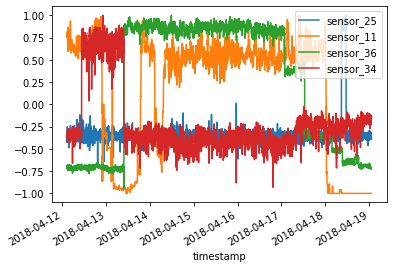

In [19]:
import matplotlib.pyplot as plt


thin_data.set_index('timestamp').plot()

<AxesSubplot:xlabel='timestamp'>

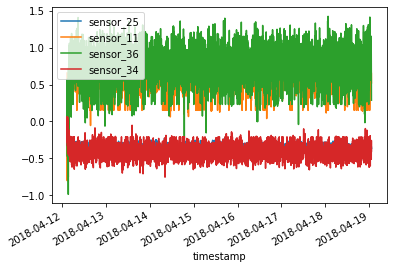

In [20]:
sample.set_index('timestamp').plot()

gave up on the PAR model from SDV after this + consulting with the SDV [slack](https://app.slack.com/client/T017A503B3M/C01GSDFSQ93) - they recommended trying out their CTGAN model which I do in notebook 6.